# Bike - Solver Development



Import modules

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np



Import bike scripts

In [2]:
import sys
sys.path.append(r"C:\Users\Mark\Documents\Important\Programming\BiKinematics")


from bikinematicsolver.bike import Bike
import bikinematicsolver.geometry as g
from bikinematicsolver.dtypes import Pos_Result

Define loading functon for our bike data

In [3]:
def load_json(filename):
    with open(filename) as f:
        data = json.load(f)
        for key,value in data.items():
            if value['object']=="Point":
                #these are stored in .json as pixel positions -> need to scale to mm (in app this as done when 'simulate' is clicked)
                value['position'] = [value['position'][0]*data['p2mm']['value'] ,value['position'][1]*data['p2mm']['value']]
    return data

## Different Suspension Types - Leverage Ratio (and now Anti-Squat (still needs validation!)

Test a variety of suspension types and see:
- If solver is able to produce solution
- If leverage ratio looks sensible
- Not really sure what to measure against - maybe leverage ratio curves from manufacturers??

Plot function

In [4]:
def show_leverage_ratio(filename):
    data = load_json(filename)
    b = Bike(data)
    b.get_suspension_motion(100,'test')
    b.calculate_suspension_characteristics('test')
    fig, ax = plt.subplots()
    x = b.solution['test']['Vertical Travel']
    y = b.solution['test']['Leverage Ratio']
    ax.plot(x, y)
    ax.set_title('Leverage Ratio')
    plt.rcParams['figure.figsize'] = [9.5, 6]
    plt.show()

def show_AS(filename):
    data = load_json(filename)
    b = Bike(data)
    b.get_suspension_motion(100,'test')
    b.calculate_suspension_characteristics('test')
    fig, ax = plt.subplots()
    x = b.solution['test']['Vertical Travel']
    y = b.solution['test']['Anti Squat Percent']
    ax.plot(x, y)
    ax.set_title('Anti Squat')
    plt.rcParams['figure.figsize'] = [9.5, 6]
    plt.show()

Data

In [5]:
horst_example = r"C:\Users\Mark\Documents\Important\Programming\BiKinematics\Savefiles\Example_VitusSommet.json"
dw_example = r'C:\Users\Mark\Documents\Important\Programming\BiKinematics\Savefiles\Example_PivotMach6.json'
split_piv_example = r'C:\Users\Mark\Documents\Important\Programming\BiKinematics\Savefiles\Example_DevinciMarshall.json'
single_piv_example = r'C:\Users\Mark\Documents\Important\Programming\BiKinematics\Savefiles\Example_OrangeFive.json'

### Horst Link Test

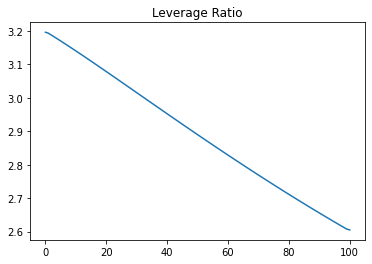

In [6]:
#%%prun -s tottime -l 10
show_leverage_ratio(horst_example)

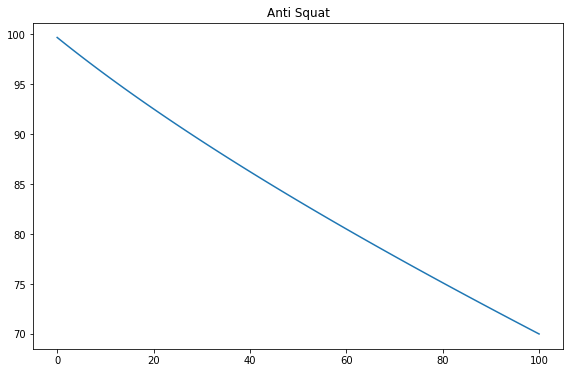

In [7]:
show_AS(horst_example)

### DW Link Test

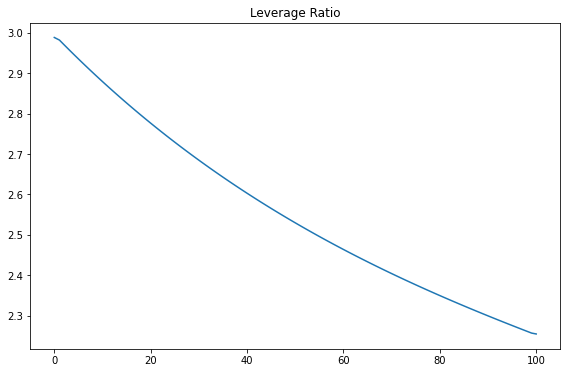

In [8]:
show_leverage_ratio(dw_example)

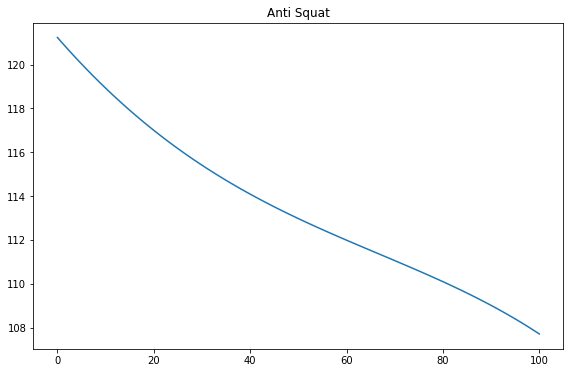

In [9]:
show_AS(dw_example)

### Single Pivot Test

For this the linkage solver is 'tricked' into solving a linkage from the pivot to rear wheel and back again - see output of kinematic link points below. Kind of slow for the circumstance, but means I don't need to bother writing a single piv specific solver

['Main_Pivot', 'Rear_Wheel', 'Main_Pivot']


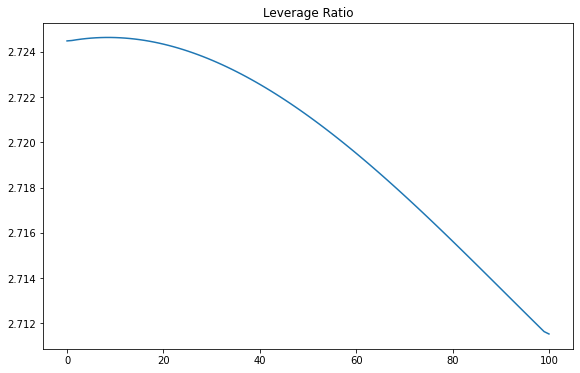

In [10]:
show_leverage_ratio(single_piv_example)

['Main_Pivot', 'Rear_Wheel', 'Main_Pivot']


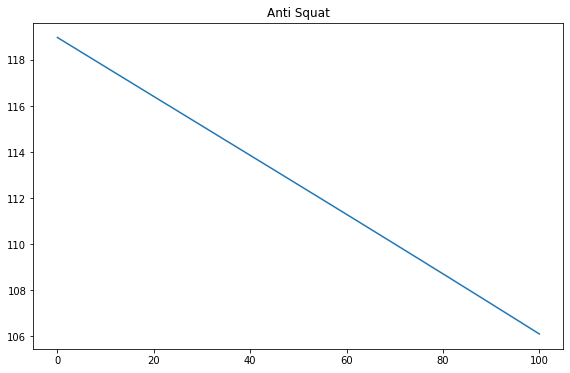

In [11]:
show_AS(single_piv_example)

### Split Pivot Test

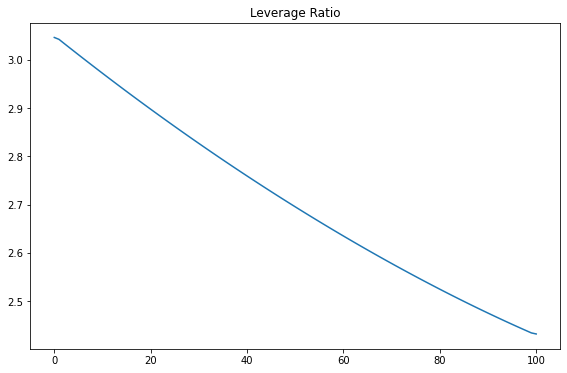

In [12]:
show_leverage_ratio(split_piv_example)

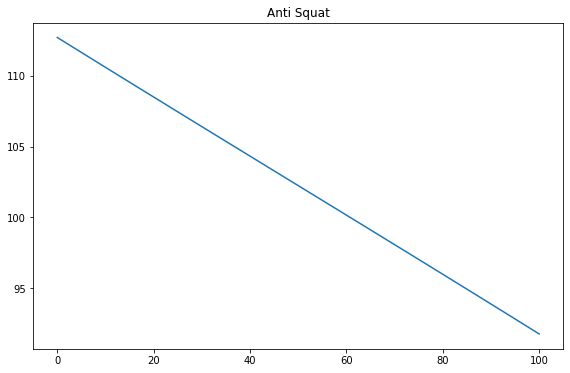

In [13]:
show_AS(split_piv_example)

## Anti Squat development

### Chainline testing

Should return the bb and rear wheel point names, and the pcd of the sprockets

In [14]:
b = Bike(load_json(horst_example))
cline = b.chainline
posns = [b.points[cline[0][0]].pos, b.points[cline[1][0]].pos]
print(cline)
print(posns)

b.get_suspension_motion(100,'')
b.calculate_suspension_characteristics('')
posn_sim_1 = b.solution[''][cline[0][0]]
rad_1 = cline[0][1] / 2
posn_sim_2 = b.solution[''][cline[1][0]]
rad_2 = cline[1][1] / 2

[('Bottom_Bracket', 121.49800736552146), ('Rear_Wheel', 210.33978224360973)]
[array([824.17910448, 432.15884861]), array([378.64072495, 454.10565046])]


Find chaninline using tangent point eqns developed here, to be copied into geometry or Bike module in future

In [15]:
def tangent_eqn(cen,r1,r2):
    delta_r = r2-r1
    z = np.add( np.power(cen[0],2) , np.power(cen[1],2))
    d = np.sqrt( np.subtract( z , np.power(delta_r,2) ) )
    
    a = np.add( cen[0]*delta_r, cen[1]*d  ) / z
    b = np.subtract( cen[1]*delta_r, cen[0]*d  ) / z
    c = r1
    ret = [a,b,c]
    return ret

In [16]:
def find_common_circle_tangent(cen1,r1,cen2,r2):
    tan_lines = []
    for i in [-1,1]:
        for j in [-1,1]: 
            cen = np.subtract(cen2 , cen1)
            #print(cen)
            tan_lines.append(tangent_eqn(cen, r1 * i, r2 * j))
    for line in tan_lines:
        s = np.add( line[0] * cen1[0] , line[1] * cen1[1])
        line[2] = np.subtract( line[2] , s )
    return tan_lines

In [17]:
def find_circle_tangent_intersection(cen,r,tangent_line):
    line = tangent_line[:]
    s = np.add( line[0] * cen[0] , line[1] * cen[1])
    line[2] = np.add( line[2] , s )
    
    z = np.add( np.power(line[0],2) , np.power(line[1],2) )
    x0 = -(line[0] * line[2]) / z + cen[0]
    y0 = -(line[1] * line[2] ) / z + cen[1]

    ic = Pos_Result(x0,y0)
    return ic

Plot moving chainline for validation

[833.19517601 834.40717807 835.65235411 836.92393796 838.21578558
 839.52230779 840.83840829 842.15943922 843.48115512 844.7996829 ]


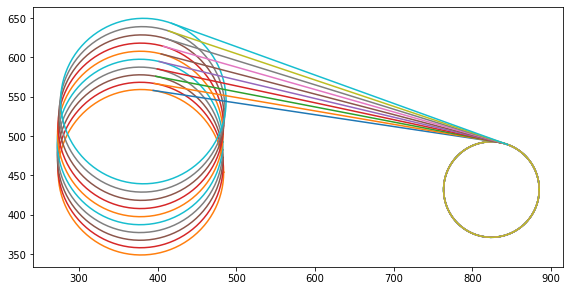

In [18]:
cen1 = posn_sim_1
r1 = rad_1
cen2 = posn_sim_2
r2 = rad_2

t_lines = find_common_circle_tangent(cen1,r1,cen2,r2)

tan_points_1 = []
tan_points_2 = []
for line in t_lines:
    tan_points_1.append(find_circle_tangent_intersection(cen1,r1,line))
    tan_points_2.append(find_circle_tangent_intersection(cen2,r2,line))

print(tan_points_1[0].x[0:-1:10])
    
#plot circles
a = np.linspace(0,2*np.pi,100)

fig,ax1 = plt.subplots()

for i in range(0,cen1.x.size,10):
    ax1.plot(cen1.x[i]+r1*np.cos(a),cen1.y[i]+r1*np.sin(a))
    ax1.plot(cen2.x[i]+r2*np.cos(a),cen2.y[i]+r2*np.sin(a))

x = [tan_points_1[0].x[0:-1:10],tan_points_2[0].x[0:-1:10]]
y = [tan_points_1[0].y[0:-1:10],tan_points_2[0].y[0:-1:10]]
ax1.plot(x,y)    
       
ax1.set_aspect(1)
plt.show()


### Big graph of everything going on to calculate AS

Code for this has been added into Bike class, and it is produced as a solution result after calling calculate_suspension_characteristics. Here is plotting to examine whether results make sense

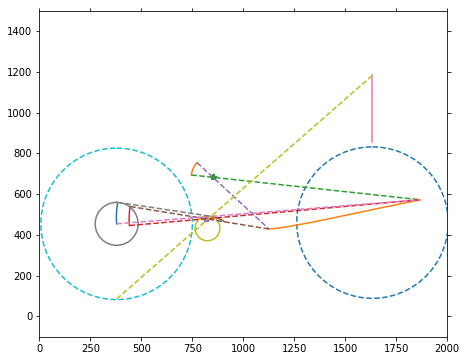

1255.000004919682
30
52
29
1100


In [19]:
b = Bike(load_json(horst_example))
b.get_suspension_motion(100,'')
b.calculate_suspension_characteristics('')
solution = b.solution['']

fig, ax = plt.subplots()
ax.clear()
x = solution['Rear_Wheel'].x
y = solution['Rear_Wheel'].y
ax.plot(x, y)
x = solution['Seatstay'].x
y = solution['Seatstay'].y
ax.plot(x, y)
x = solution['Upper_Pivot'].x
y = solution['Upper_Pivot'].y
ax.plot(x, y,'*')
x = solution['Horst_Pivot'].x
y = solution['Horst_Pivot'].y
ax.plot(x, y)
x = solution['Main_Pivot'].x
y = solution['Main_Pivot'].y
ax.plot(x, y,'*')
x = solution['IFC'].x
y=solution['IFC'].y
ax.plot(x, y)
x = solution['AS_Point'].x
y = solution['AS_Point'].y
ax.plot(x, y)
a = np.linspace(0,2*np.pi,100)
x = solution['Rear_Wheel'].x[0]*np.ones_like(a) + b.chainline[-1][1] * 0.5 * np.sin(a)
y = solution['Rear_Wheel'].y[0]*np.ones_like(a) + b.chainline[-1][1] * 0.5 * np.cos(a)
ax.plot(x,y)
x = solution['Bottom_Bracket'].x[0]*np.ones_like(a) + b.chainline[-2][1] * 0.5 * np.sin(a)
y = solution['Bottom_Bracket'].y[0]*np.ones_like(a) + b.chainline[-2][1] * 0.5 * np.cos(a)
ax.plot(x,y)
x = solution['Rear_Wheel'].x[0]*np.ones_like(a) + 29.25*25.4 * 0.5 * np.sin(a)
y = solution['Rear_Wheel'].y[0]*np.ones_like(a) + 29.25*25.4 * 0.5 * np.cos(a)
ax.plot(x,y,'--')
x = solution['Front_Wheel'].x[0]*np.ones_like(a) + 29.25*25.4 * 0.5 * np.sin(a)
y = solution['Front_Wheel'].y[0]*np.ones_like(a) + 29.25*25.4 * 0.5 * np.cos(a)
ax.plot(x,y,'--')

x = solution['Instant Centre'].x
y = solution['Instant Centre'].y
plt.xlim([0,2000])
plt.ylim([-100,1500])
ax.plot(x, y)

x = [ solution['Seatstay'].x[0] , solution['Instant Centre'].x[0] ]
y = [ solution['Seatstay'].y[0] , solution['Instant Centre'].y[0] ]
ax.plot(x,y,'--')
x = [ solution['Horst_Pivot'].x[0] , solution['Instant Centre'].x[0] ]
y = [ solution['Horst_Pivot'].y[0] , solution['Instant Centre'].y[0] ]
ax.plot(x,y,'--')

x = [ solution['Seatstay'].x[-1] , solution['Instant Centre'].x[-1] ]
y = [ solution['Seatstay'].y[-1] , solution['Instant Centre'].y[-1] ]
ax.plot(x,y,'--')
x = [ solution['Horst_Pivot'].x[-1] , solution['Instant Centre'].x[-1] ]
y = [ solution['Horst_Pivot'].y[-1] , solution['Instant Centre'].y[-1] ]
ax.plot(x,y,'--')
x = [ solution['Rear_Wheel'].x[0] , solution['Instant Centre'].x[0] ]
y = [ solution['Rear_Wheel'].y[0] , solution['Instant Centre'].y[0] ]
ax.plot(x,y,'--')
x = [ solution['CLINE_1'].x[0] , solution['CLINE_2'].x[0] ]
y = [ solution['CLINE_1'].y[0] , solution['CLINE_2'].y[0] ]
ax.plot(x,y,'--')
x = [ solution['Tyre_Contact'].x[0] , solution['AS_Point'].x[0] ]
y = [ solution['Tyre_Contact'].y[0] , solution['AS_Point'].y[0] ]
ax.plot(x,y,'--')

ax.set_aspect('equal')
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.show()

print(str(- solution['Rear_Wheel'].x[0] + solution['Front_Wheel'].x[0]))
print(b.params['chainring_teeth'])
print(b.params['cassette_teeth'])
print(b.params['wheel_size'])
print(b.params['cog_height'])